<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_Post_Trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [4]:
from sklearn.preprocessing import MinMaxScaler
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def calAccuracy(x, check_his = False):
  """
  Calculate the accuracy
  return: accuracy
  """
  if check_his:
    assert x not in historical_accuracy
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)
  historical_accuracy[x] = y
  return y

def stateNormalize(scaler, detection, param_val):
  detection = np.append(detection, param_val)
  assert scaler.data_range_.shape[0] == detection.shape[0]
  return scaler.transform([detection])[0]

def stateDenormalized(scaler, cur_state):
  res = scaler.inverse_transform([cur_state])
  return (res[0][:-1], int(round(res[0][-1])))

def detect(detect_range, x):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  return [calAccuracy(pos) if pos in x_range else 0 for pos in x_detect_range]


## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-3, -1, 0, 1, 3] # also input dim
step_options = [-8, -3, -1, 0, 1, 3, 8] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8

#memory variables
mem_size = int(len(x_range)/5)
batch_size = int(mem_size/2)
assert batch_size <= mem_size
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

## Check if the max change if different data

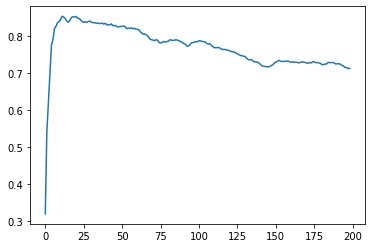

11


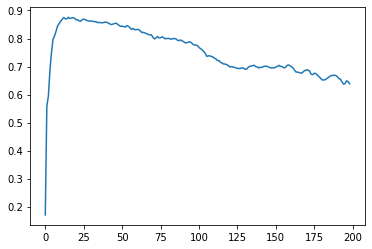

15


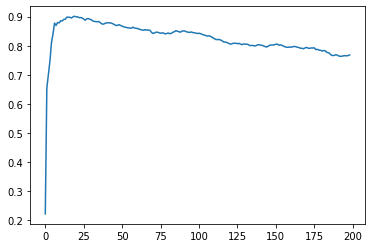

19


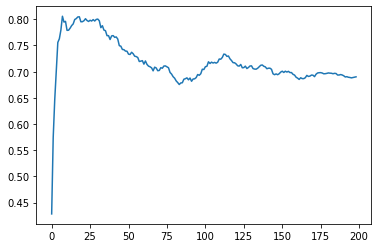

7


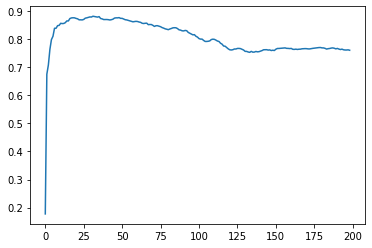

31


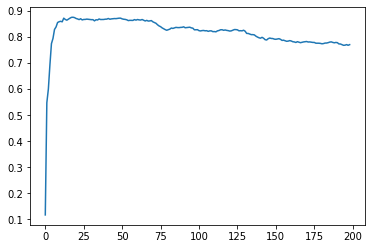

18


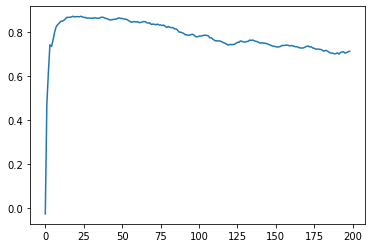

18


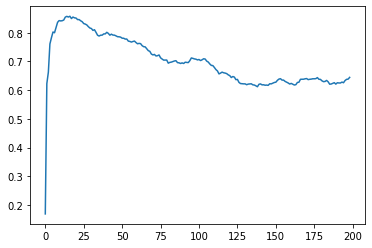

16


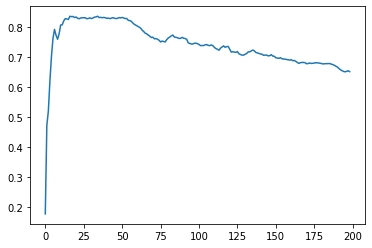

16


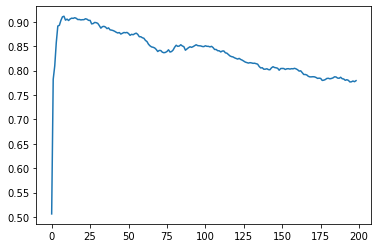

8


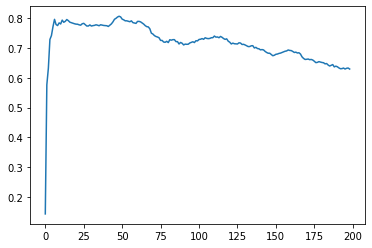

48


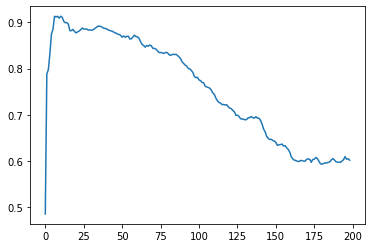

6


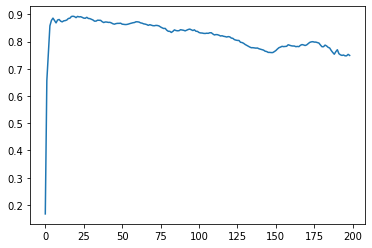

18


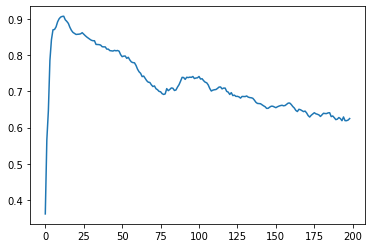

12


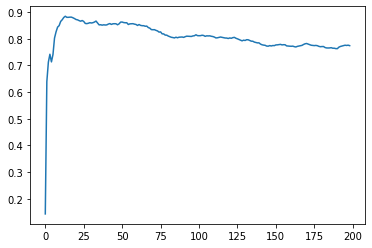

13


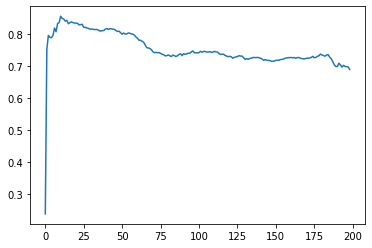

10


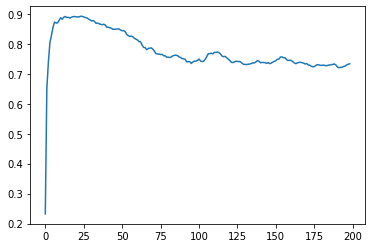

23


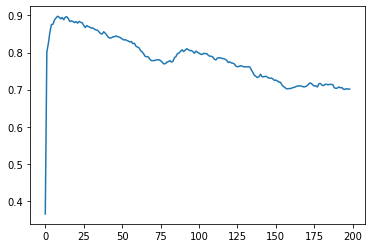

8


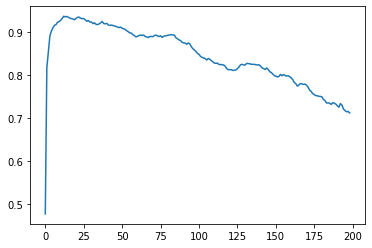

12


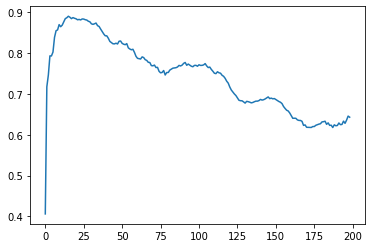

15


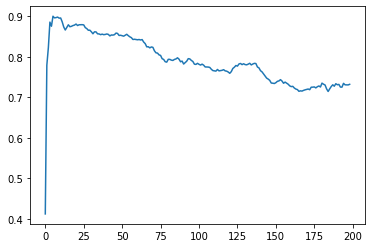

5


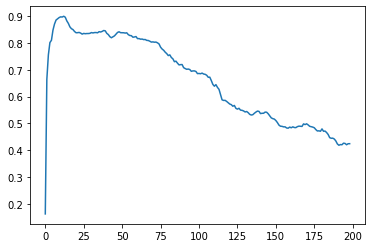

12


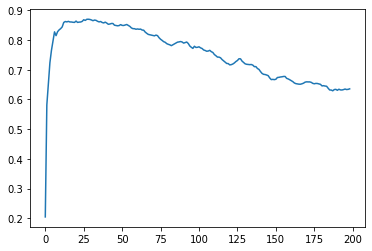

28


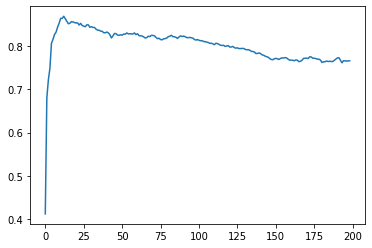

12


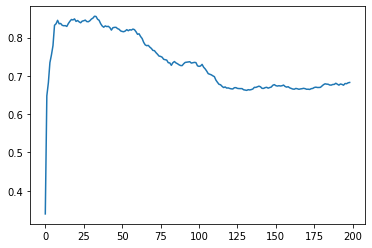

32


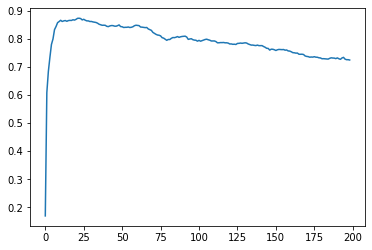

22


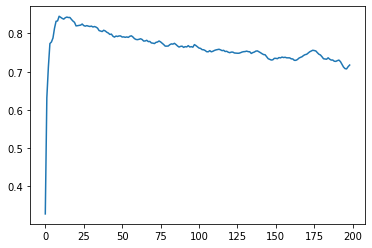

9


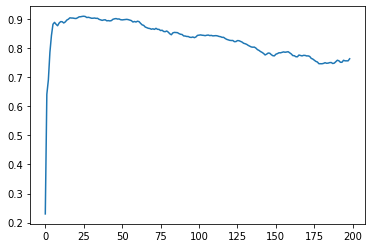

25


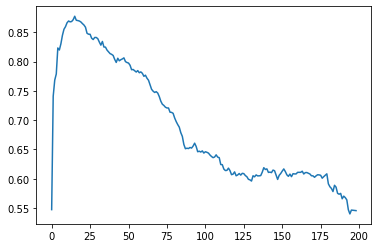

15


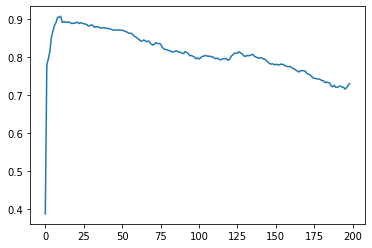

10


In [55]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
for i in range(30):
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train = X[train_indices]
  X_test = X[test_indices]
  Y_train = Y[train_indices]
  Y_test = Y[test_indices]
  accuracy_list = []
  for x in x_range:
    accuracy_list.append(calAccuracy(x))
  plt.plot(accuracy_list)
  plt.show()
  print(np.argmax(accuracy_list))

## Find a accuracy map with relatively wide range of accuracy

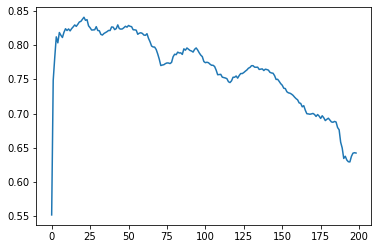

21


In [69]:
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

## Create a scaler for param

In [56]:
data = [[*([0]*len(detect_range)), 1], [*([1]*len(detect_range)), max(x_range)]]
scaler = MinMaxScaler()
scaler.fit(data)
scaler.data_range_.shape

(6,)

## Game Initialization

In [0]:
historical_accuracy = {}
x = 150
detection = detect(detect_range, x)
init_state = stateNormalize(scaler, detection, x)


done = False
step_ctr = 0

cur_state = init_state

In [0]:
accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))
